In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.cluster.hierarchy as sch
from seaborn.matrix import dendrogram
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


wine = pd.read_csv('wine.csv')


In [2]:
y = wine['quality']
X = wine.drop(columns=['quality'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [4]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('MAE', round(mae,2))


MAE 0.42


In [5]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

100%|===================| 976/980 [00:20<00:00]        

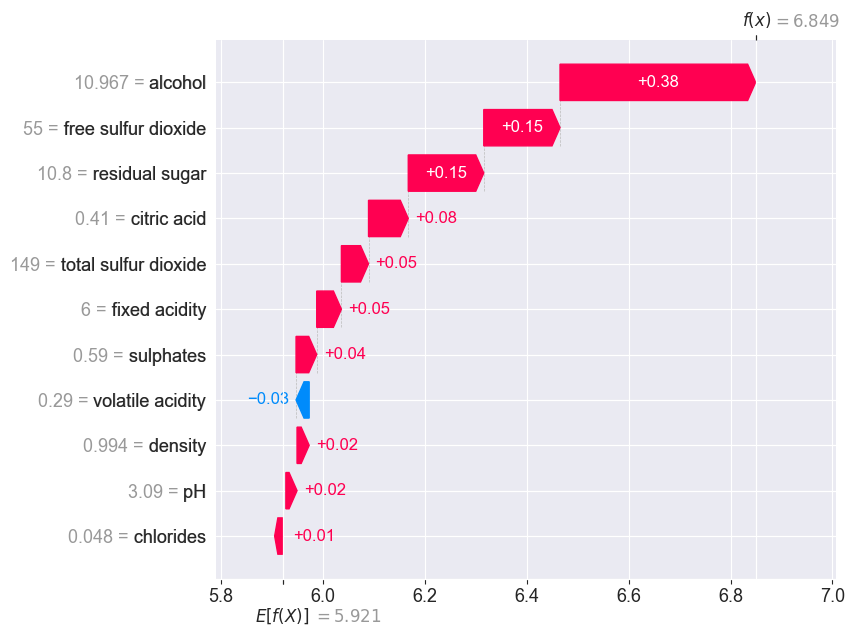

In [6]:
shap.plots.waterfall(shap_values[0],  max_display=11)

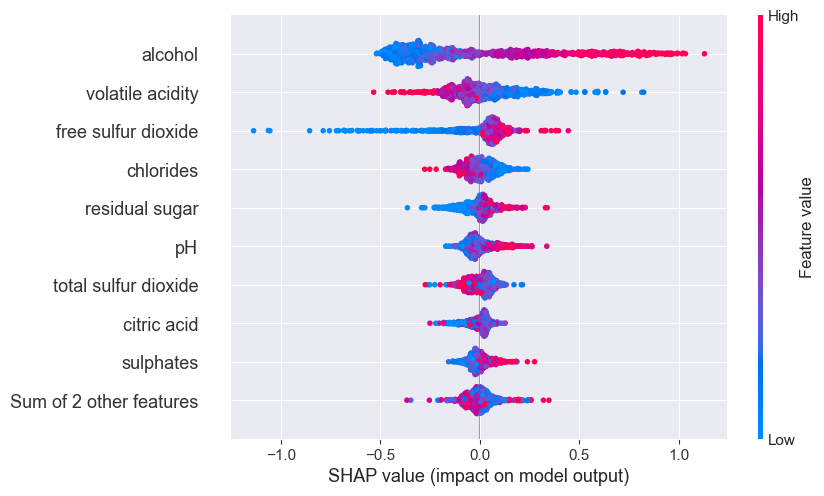

In [7]:
shap.plots.beeswarm(shap_values)

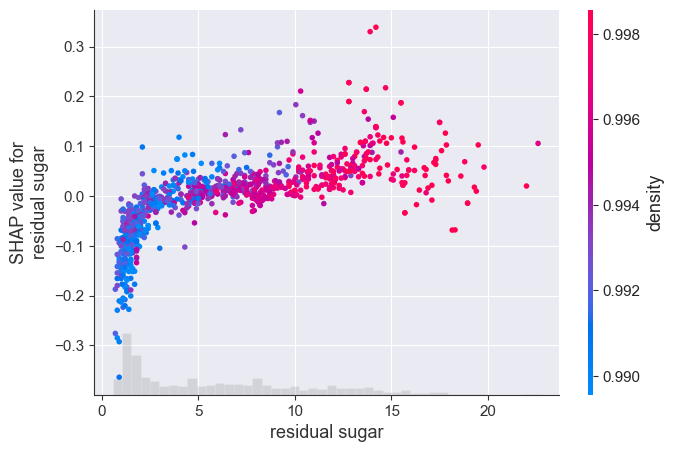

In [8]:
shap.plots.scatter(shap_values[:, 'residual sugar'], color=shap_values[:, 'density'])

In [9]:
corr    = X_train.corr()


<Axes: >

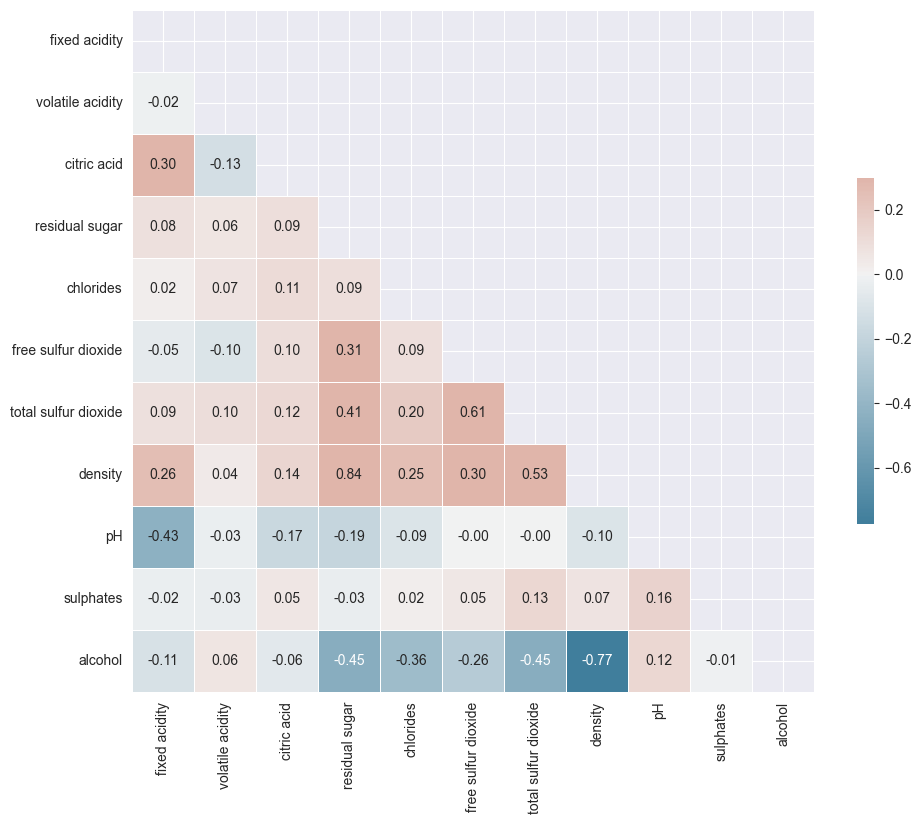

In [10]:
mask    = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 9))
cmap    = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

In [11]:
correlation_matrix = X_train.corr()
correlation_matrix = np.corrcoef(correlation_matrix)
correlation_matrix = np.abs(correlation_matrix)
dist_matrix = 1 - correlation_matrix

<Axes: >

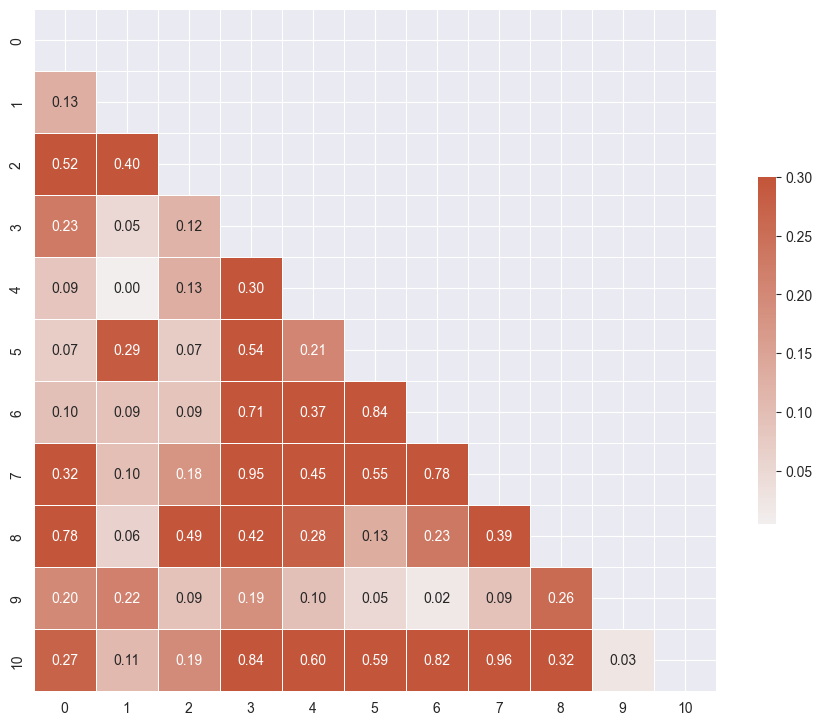

In [12]:
mask    = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 9))
cmap    = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

In [13]:
for number, name in enumerate(X_train.columns):
    print(number, name)

0 fixed acidity
1 volatile acidity
2 citric acid
3 residual sugar
4 chlorides
5 free sulfur dioxide
6 total sulfur dioxide
7 density
8 pH
9 sulphates
10 alcohol


In [14]:
clustering = sch.linkage(dist_matrix, method='complete')
clustering


array([[ 7.        , 10.        ,  0.23148261,  2.        ],
       [ 3.        , 11.        ,  0.4541262 ,  3.        ],
       [ 0.        ,  8.        ,  0.45858828,  2.        ],
       [ 5.        ,  6.        ,  0.50955045,  2.        ],
       [ 2.        , 13.        ,  0.97015649,  3.        ],
       [12.        , 14.        ,  0.97190804,  5.        ],
       [ 1.        ,  9.        ,  1.21044244,  2.        ],
       [ 4.        , 16.        ,  1.28773721,  6.        ],
       [15.        , 17.        ,  1.60830278,  5.        ],
       [18.        , 19.        ,  2.07719694, 11.        ]])

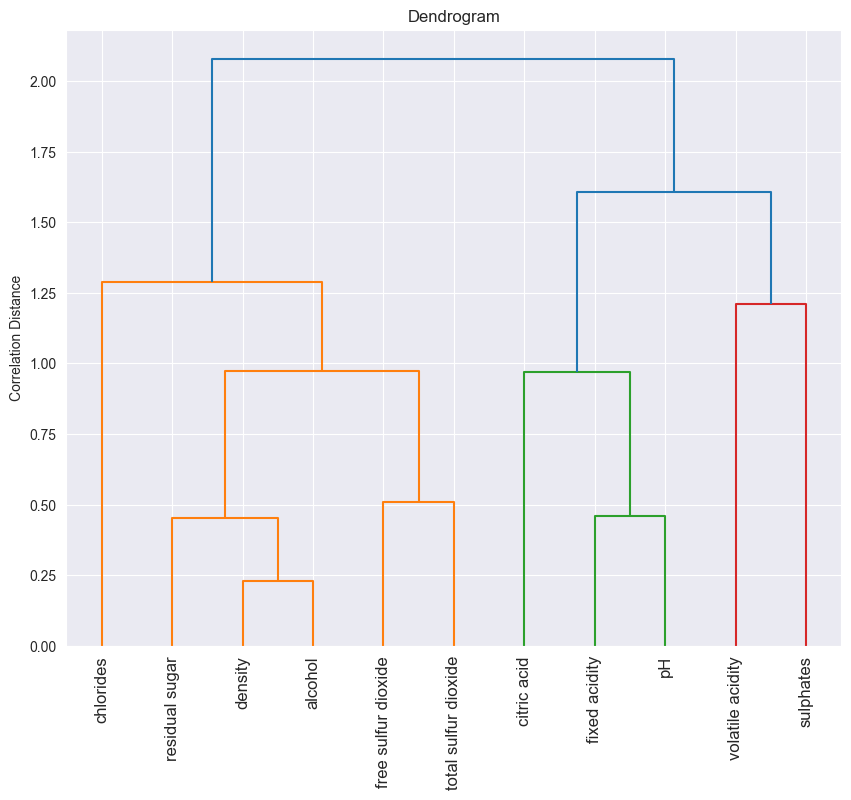

In [15]:
plt.figure(figsize=(10, 8))
plt.title('Dendrogram')
dend       = sch.dendrogram(clustering, labels=X_train.columns)
plt.xticks(rotation=90)
plt.ylabel('Correlation Distance')
plt.show()

In [16]:
masker = shap.maskers.Partition(X_train, clustering=clustering)
explainer2 = shap.PartitionExplainer(model.predict, masker=masker)
shap_values2 = explainer2(X_test)

PartitionExplainer explainer: 981it [02:22,  6.44it/s]                         


<Axes: xlabel='mean(|SHAP value|)'>

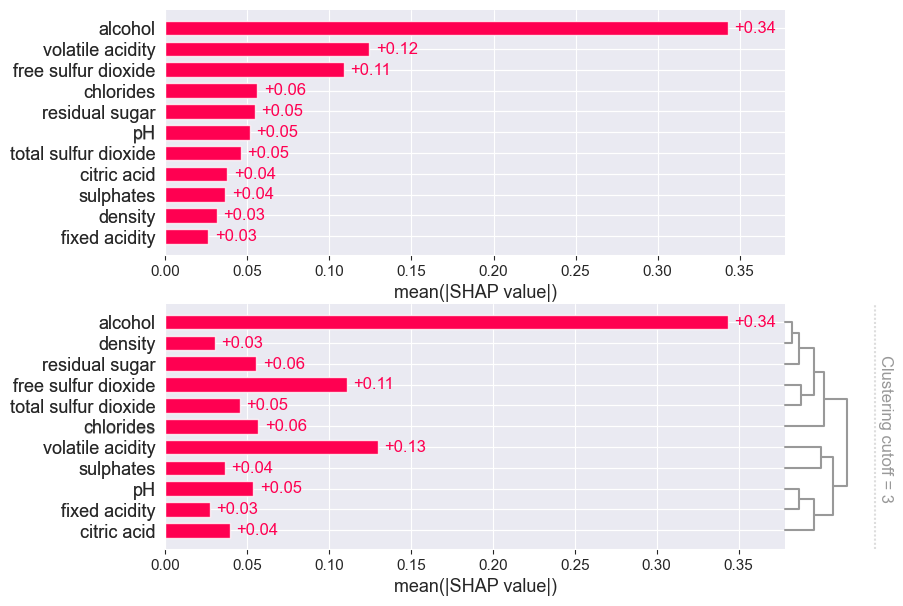

In [21]:
fig = plt.figure(figsize=(6,12))
ax0 = fig.add_subplot(211)
shap.plots.bar(shap_values, max_display=11, show=False)
ax1 = fig.add_subplot(212)
shap.plots.bar(shap_values2, max_display=11, show=False, clustering_cutoff=3.0)

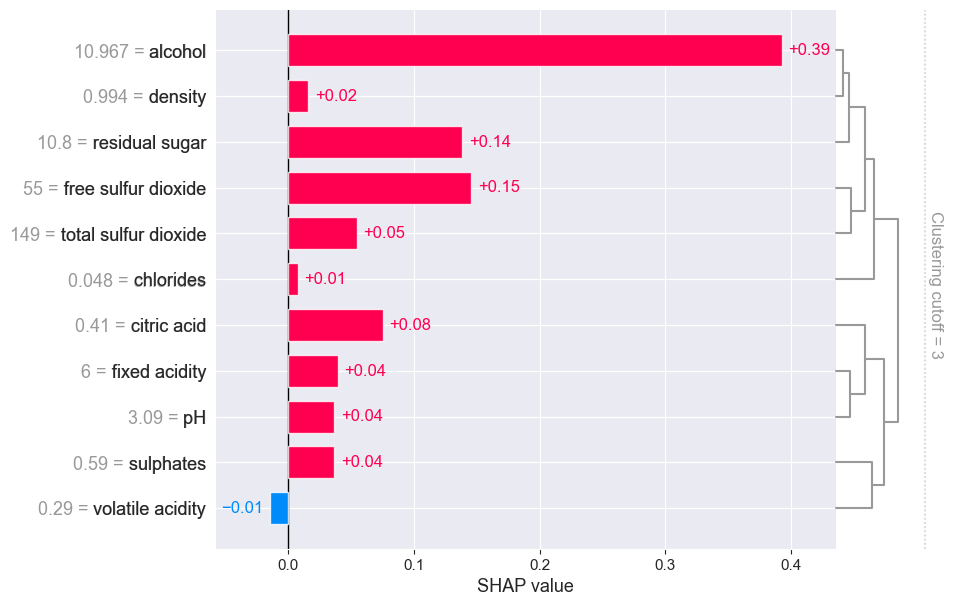

In [22]:
shap.plots.bar(shap_values2[0]  , max_display=11 , clustering_cutoff=3)

In [27]:
ind_test, ind_train = np.where(X_test['alcohol'].values >12), np.where(X_train['alcohol'].values >12)
X_test_sub, X_train_sub = X_test.iloc[ind_test], X_train.iloc[ind_train]

explainer_sub = shap.Explainer(model, X_train_sub)
shap_values_sub = explainer_sub(X_test_sub)

shap_values_sub_all = shap_values[ind_test]

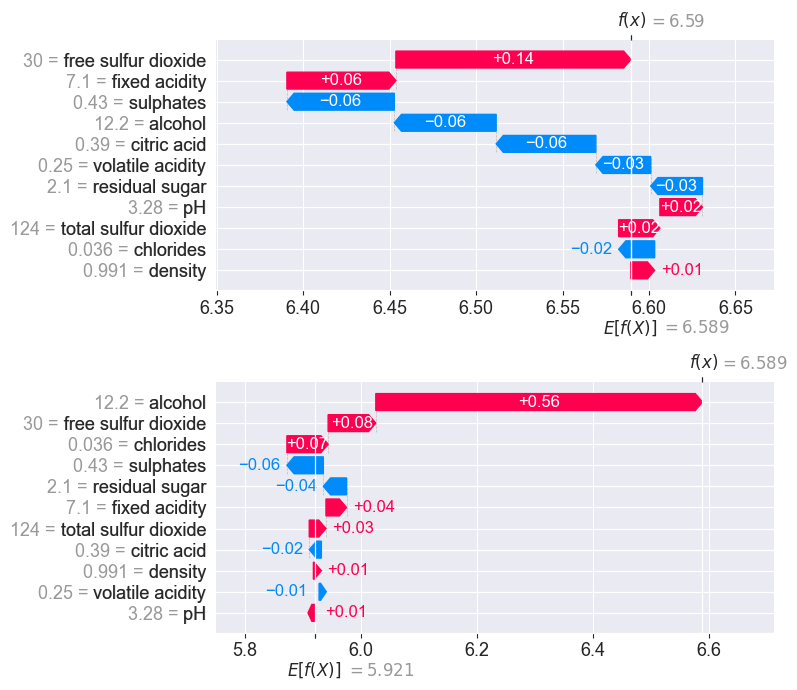

In [44]:
fig = plt.figure(figsize=(6,12))
ax0 = fig.add_subplot(211)
ax0 = shap.plots.waterfall(shap_values_sub[1], max_display=11,  show=False)
ax1 = fig.add_subplot(212)
ax1 = shap.plots.waterfall(shap_values_sub_all[1], max_display=11,show=False)

plt.tight_layout()
plt.show()

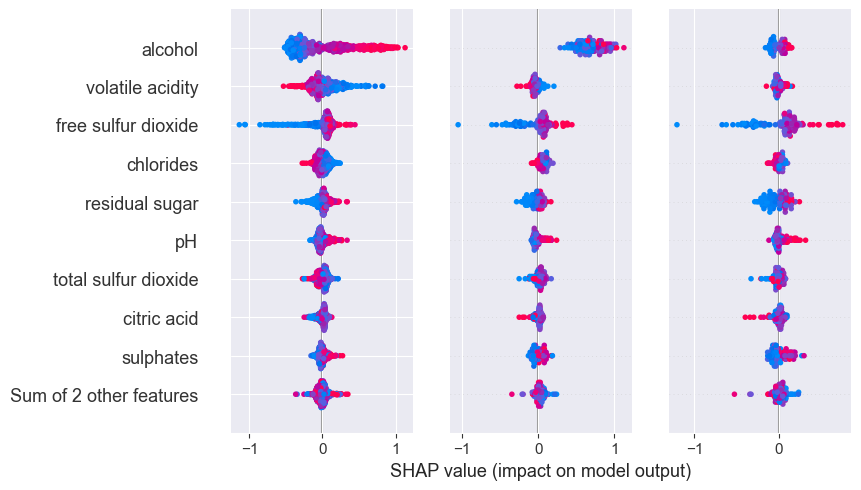

In [55]:
fig = plt.figure(figsize=(6,12))
ordered = np.argsort(abs(shap_values.values).mean(axis=0))[::-1]
plt.subplot(131)
shap.plots.beeswarm(shap_values, show=False, color_bar=False, order=ordered)
plt.xlabel("")
plt.subplot(132)
shap.plots.beeswarm(shap_values_sub_all, show=False, color_bar=False, order=ordered)
plt.gca().set_yticks([])
plt.ylabel("")
plt.subplot(133)
shap.plots.beeswarm(shap_values_sub, show=False, color_bar=False, order=ordered)
plt.gca().set_yticks([])
plt.ylabel("")
plt.xlabel("")
plt.show()